# `Материалы кафедры ММП факультета ВМК МГУ. Введение в глубокое обучение.`

# `Занятие 02. Инициализация и регуляризация нейросетей`

## `Занятие провел: Голубев Роман (@Tetragrammaton_123)  `

## `Материалы составил: Алексеев Илья (@voorhs)`

### `Москва, Весенний семестр 2026`


Источники:
- **Dropout**: [Nitish Srivastava et al., 2014](https://jmlr.org/papers/v15/srivastava14a.html), примерно 61к цитирований
- **Batch Normalization**: [Sergey Ioffe, Christian Szegedy, 2015](https://arxiv.org/abs/1502.03167), примерно 65к цитирований
- **Xavier / Glorot initialization**: [Xavier Glorot, Yoshua Bengio, 2010](https://proceedings.mlr.press/v9/glorot10a.html), примерно 30к цитирований
- **ResNet (residual connections)**: [Kaiming He et al., 2015](https://arxiv.org/abs/1512.03385), примерно 300к цитирований
- Про симметрии и остаточные связи: https://habr.com/ru/articles/688350/
- Про сглаживание ландшафта функции потерь: [Hao Li et al., 2017](https://arxiv.org/abs/1712.09913), примерно 3к цитирований


На этом занятии обсуждаем основные функции активации и их влияние на инициализацию нейронных сетей, а также способы увеличения стабильности обучения. Рассмотрим основные приёмы для регуляризации: dropout и влияние стохастической оптимизации.

---

## Вспоминаем основы (дифференциалы и градиенты)

Вспомним базовые определения на примере функции $f(x)={1\over2}x^TAx$, $A\succ0$, то есть $A$ положительно определённая матрица.

- Дифференциалом мы называем линейную часть приращения функции $f$:

$$
\mathrm{d} f=Df(x)[\mathrm{d}x]=(\mathrm{d}x)^TAx.
$$

- Производной Фреше (для нас будет достаточен следующий уровень строгости) мы называем линейный оператор, результатом действия которого является дифференциал:

$$
Df(x)[\cdot]=\langle Ax,\cdot\rangle.
$$

- Частной производной мы называем матрично-векторное представление производной Фреше:

$$
{\partial f\over\partial x}=\nabla_x f=Ax.
$$

В зависимости от вида функции $f$ частную производную называют градиентом или матрицей Якоби. Мы для простоты всегда будем называть это градиентом.

Вспомним важное свойство &ndash; инвариантность первого вида дифференциала. Если $y=g(z)$, $z=f(x)$, то

$$
\mathrm{d}y=\left\langle{\partial y\over\partial z},\mathrm{d}z\right\rangle=\left\langle{\partial y\over\partial x},\mathrm{d}x\right\rangle.
$$


## Градиенты линейного слоя

Пусть $z=f(x)=Wx+b$, где

- $f:\mathbb{R}^d\to\mathbb{R}^h$,
- $x\in\mathbb{R}^{d}$,
- $W\in\mathbb{R}^{h\times d}$,
- $b\in\mathbb{R}^h$.

Найдём $\nabla_x L$, $\nabla_W L$ при известном $\nabla_z L\in\mathbb{R}^h$. Дифференциал:

$$
\mathrm{d}z=(\mathrm{d}W)x+W\,\mathrm{d}x+\mathrm{d}b.
$$

По свойству инвариантности первого вида дифференциала:

$$
\begin{align}
\mathrm{d}L &= \langle \nabla_z L, dz \rangle \\
             &= \langle \nabla_z L, (\mathrm{d}W)x \rangle + \langle \nabla_z L, W\,\mathrm{d}x \rangle + \langle \nabla_z L, \mathrm{d}b \rangle =\\
             &= \langle \underbrace{(\nabla_z L)x^T}_{\nabla_W L}, \mathrm{d}W \rangle
              + \langle \underbrace{W^T(\nabla_z L)}_{\nabla_x L}, \mathrm{d}x \rangle
              + \langle \underbrace{\nabla_z L}_{\nabla_b L}, \mathrm{d}b \rangle.
\end{align}
$$


## Градиенты сигмоиды

Пусть $a=f(z)=\frac{1}{1+\exp(-z)}$, где

- $f: \mathbb{R}\to\mathbb{R}$, применяется поэлементно,
- $z$ &ndash; скалярное значение, функция $f$ применяется к числу, нам не важно, что конкретно такое $z$,
- $a$ &ndash; результат применения функции $f$ к $z$.

Найдём $\nabla_z L$ при известном $\nabla_a L \in \mathbb{R}$. Дифференциал:

$$
\begin{align}
\mathrm{d}a &= f(z)(1-f(z))\,\mathrm{d}z =\\
             &= a(1-a)\,\mathrm{d}z.
\end{align}
$$

По свойству инвариантности первого вида дифференциала:

$$
\begin{align}
\mathrm{d}L &= \langle \nabla_a L, \mathrm{d}a \rangle =\\
             &= \langle \nabla_a L, a(1-a)\,\mathrm{d}z \rangle =\\
             &= \langle \underbrace{(\nabla_a L)\,a(1-a)}_{\nabla_z L}, \mathrm{d}z \rangle.
\end{align}
$$

<font color='Orange'>**Вопрос:**</font> Что вы видите в этой формуле? Чему равен градиент $\nabla_z L$? Какое у него наибольшее значение? Подумайте, как это связано с величиной нормы градиента и почему это может быть важно при обучении нейросетей.


#### Ответ:

Наибольшее значение, которое принимает $a(1 - a)$ равно $\frac{1}{4}$ и достигается при $a = \frac{1}{2}$. Из этого мы получаем, что нормы градиентов после сигмоиды при обратном распространеннии ошибки уменьшаться в 4 раза, что может приводить к затуханию градиента, об этом далее.

## Градиенты LogSoftmax


Вспомним определение LogSoftmax:

$$
a_j = \log\frac{e^{z_j}}{\sum_{i=1}^K e^{z_i}}
= z_j - \log\left(\sum_{i=1}^K e^{z_i}\right).
$$

Softmax:

$$
p_i = \frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}.
$$

где $a, z \in \mathbb{R}^K$ и операции $\log$, $\exp$ применяются покомпонентно. Найдём $\nabla_z L$ при известном $\nabla_a L$. Дифференциал:

$$
\begin{align}
\mathrm{d}a_j
&= \mathrm{d}z_j
- \mathrm{d}\log\left(\sum_{i=1}^K e^{z_i}\right) \\
&= \mathrm{d}z_j
- \frac{\sum_{i=1}^K e^{z_i}\,\mathrm{d}z_i}
{\sum_{i=1}^K e^{z_i}} \\
&= \mathrm{d}z_j
- \sum_{i=1}^K
\frac{e^{z_i}}{\sum_{k=1}^K e^{z_k}}
\,\mathrm{d}z_i \\
&= \mathrm{d}z_j
- \sum_{i=1}^K p_i\,\mathrm{d}z_i.
\end{align}
$$

Теперь используем инвариантность первого дифференциала:

$$
\begin{align}
\mathrm{d}L
&= \langle \nabla_a L, \mathrm{d}a \rangle \\
&= \sum_{j=1}^K (\nabla_{a_j} L)\,\mathrm{d}a_j \\
&= \sum_{j=1}^K (\nabla_{a_j} L)
\left(
\mathrm{d}z_j
- \sum_{i=1}^K p_i\,\mathrm{d}z_i
\right) \\
&= \sum_{j=1}^K (\nabla_{a_j} L)\,\mathrm{d}z_j
- \left(\sum_{j=1}^K \nabla_{a_j} L\right)
\left(\sum_{i=1}^K p_i\,\mathrm{d}z_i\right).
\end{align}
$$

Перегруппируем по $\mathrm{d}z_i$:

$$
\mathrm{d}L
=
\sum_{i=1}^K
\left(
\nabla_{a_i} L
-
p_i \sum_{j=1}^K \nabla_{a_j} L
\right)
\mathrm{d}z_i.
$$

Следовательно,

$$
\nabla_z L
=
\nabla_a L
-
p \left(\sum_{j=1}^K \nabla_{a_j} L\right),
$$

где $p = \mathrm{softmax}(z)$.


## Затухание градиентов

Выше мы вывели формулу для градиентов весов линейного (полносвязного) слоя:

$$
z_i = W_i x_{i-1} \Rightarrow
\begin{cases}
\nabla_{W_i} L = (\nabla_{z_i} L) x_{i-1}^T,\\
\nabla_{x_{i-1}} L = W_i^T (\nabla_{z_i} L).
\end{cases}
$$

А также градиенты функции активации в общем виде:

$$
x_i = f(z_i) \Rightarrow \nabla_{z_i} L = (\nabla_{x_i} L) \frac{\partial x_i}{\partial z_i}.
$$

Нетрудно вывести формулу градиентов весов на $i$-ом слое ($i=\overline{1,L}$):

$$
\begin{align}
\nabla_{W_i} L &= (\nabla_{z_i} L) x_{i-1}^T =\\
                &= \left((\nabla_{x_i} L) \frac{\partial x_i}{\partial z_i}\right) x_{i-1}^T =\\
                &= \left((W_{i+1}^T (\nabla_{z_{i+1}} L)) \frac{\partial x_i}{\partial z_i}\right) x_{i-1}^T =\\
                &= \left(\left(W_{i+1}^T \left((\nabla_{x_{i+1}} L) \frac{\partial x_{i+1}}{\partial z_{i+1}}\right)\right) \frac{\partial x_i}{\partial z_i}\right) x_{i-1}^T =\\
                &\ldots =\\
                &= \left(\prod_{j=i+1}^L W_j^T\right) (\nabla_{x_L} L) \left(\prod_{j=i+1}^L \frac{\partial x_j}{\partial z_j}\right) x_{i-1}^T.
\end{align}
$$

Эта формула является очень ценной для понимания того, в чем различие обучения первых слоев нейросети ($i=1,2,3,\ldots$) и последних ($i=L,L-1,L-2,\ldots$). Давайте проанализируем норму полученного градиента:

$$
\|\nabla_{W_i} L\| \leqslant \left(\prod_{j=i+1}^L \|W_j\|\right) \left(\prod_{j=i+1}^L \left\| \frac{\partial x_j}{\partial z_j} \right\|\right) \|x_{i-1}\|.
$$

Рассмотрим случай, когда в качестве функции $x_i = f(z_i)$ выбрана сигмоида. Известно следующее:

$$
\begin{cases}
\frac{\partial x_j}{\partial z_j} = x_j(1-x_j),\\
0 < x_j < 1
\end{cases}
\quad \Rightarrow \quad
0 < \left\| \frac{\partial x_j}{\partial z_j} \right\| < 1 \quad \Rightarrow \quad
\prod_{j=i+1}^L \left\| \frac{\partial x_j}{\partial z_j} \right\| \xrightarrow{L \to \infty} 0.
$$

Градиенты весов первых слоев будут значительно меньше градиентов последних слоев. Это означает две вещи:

- выход нейросети практически не зависит от преобразований, совершённых на первых слоях, т.е. “информация” не доходит до конца;
- во время оптимизации веса первых слоев будут меняться намного медленнее, чем веса последних слоев.

Данное явление называют затуханием градиентов.


## Функции активации

После того как мы разобрались с затуханием градиентов, возникает вопрос:

<font color='Orange'>**Вопрос:**</font> Как вы думаете как можно уменьшить затухание градиентов?

#### Ответ:

Один из возможных ответов &ndash; уменьшить число слоёв, однако, на практике мы хотим как можно больше  слоев. Чем больше слоёв нейронной сети, тем более сложные зависимости она может изучить. Поэтому более разумным будет следующий способ:
- Использовать другие функции активации, которые меньше подвержены затуханию градиентов (ReLU, LeakyReLU, ELU и другие, которые мы разберём далее)

<font color='Orange'>**Вопрос:**</font> Если мы хотим использовать использовать другие функции активакции, то какие свойства мы ожидаем от таких функций?

#### Ответ:

1. Сопротивление затуханию градиентов.  
2. Возможность тождественного преобразования (слой может оставить признаки без изменений, если это оптимально).  
3. Гладкость функции для стабильной работы оптимизатора.  
4. Вычислительная эффективность.

### Тождественное преобразование

Нейросеть с сигмоидной функцией активации нельзя научить тождественному преобразованию, т.к. вход сигмоиды &ndash; это $\mathbb{R}$, а выход &ndash; это отрезок $[0,1]$. Поддерживать тождественное преобразование &ndash; это разумное требование к нейросети, т.к. иногда лучшее, что может сделать слой &ndash; это просто не испортить имеющиеся признаки.

### Вычислительная сложность

Сложные функции по типу синусов, экспонент и логарифмов на компьютере считаются с помощью рядов Тейлора. При большом числе слоев число операций, требуемых для вычисления функций активации, может сильно возрасти. Поэтому, например, выбор $\text{ReLU}$ вместо $\sigma$ может заметно ускорить проход по нейросети.

### Гладкость

Функцию называют гладкой, если её производная является непрерывной функцией. Для таких функций методы оптимизации сходятся на порядок быстрее, поэтому на первый взгляд кажется, что $\text{ReLU},\text{LeakyReLU}$ следует сразу вычеркнуть из списка. Но поскольку свойство гладкости нарушается лишь в одной точке, на практике методы гладкой оптимизации работают и для них. Существует даже термин: дифференцируемые в смысле нейросетей функции.


| Функция                                                      | Затухание | Тождество | Гладкость | Сложность |
| ------------------------------------------------------------ | --------- | --------- | --------- | --------- |
| $\sigma(z)=\dfrac{1}{1+e^{-z}}$                              | FAIL      | FAIL      | OK        | FAIL      |
| $\tanh(z)=2\sigma(2z)-1$                                     | FAIL      | OK        | OK        | FAIL      |
| $\text{ReLU}(z)=\max\{0,z\}$                                 | OK        | FAIL      | OK/FAIL   | OK        |
| $\text{LeakyReLU}(z)=\begin{cases}z, & z\geqslant0,\\\alpha z,& \text{otherwise},\end{cases}$ | OK        | OK        | OK/FAIL   | OK        |
| $\text{ELU}(z)=\begin{cases}z, & z\geqslant0,\\e^z-1,& \text{otherwise}.\end{cases}$ | OK        | OK        | OK        | FAIL      |
| $\text{GELU}(z)=z\cdot\Phi(z)$                               | ОК        | ОК        | ОК        | FAIL      |
| $\text{Swish}(z)=z\cdot\sigma(z)$                            | ОК        | ОК        | ОК        | FAIL      |
| $\text{Mish}(z)=z\cdot\tanh(\text{softplus}(z))$             | ОК        | ОК        | ОК        | FAIL      |
| $\text{ReLU6}(z)=\min(\max(0,z),6)$                          | ОК        | FAIL      | ОК/FAIL   | OK        |

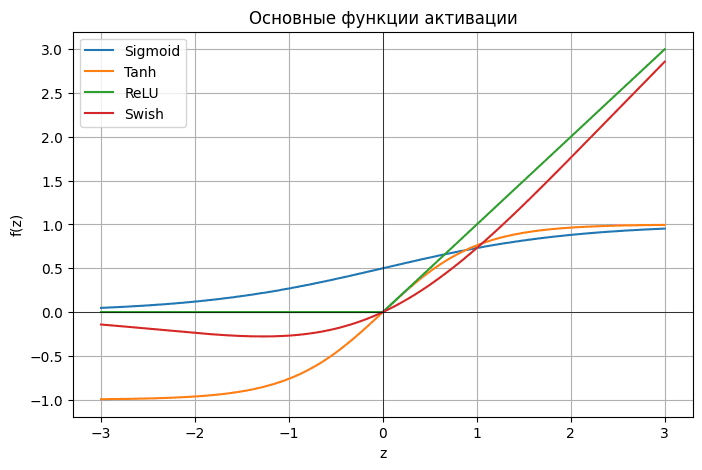

## Инициализация весов

Вернемся к выражению для нормы градиентов весов:
$$
\|\nabla_{W_i} L \|\leqslant \underbrace{\left(\prod_{j={i+1}}^L\|W_j\|\right)}_{\text{init.}}\underbrace{\left(\prod_{j={i+1}}^L\left\|{\partial a_j\over\partial z_j}\right\|\right)}_\text{act.fun., norm.}\underbrace{\|a_{i-1}\|}_\text{norm.}
$$
Проанализируем методы, которые мы успели ввести выше.

- Выбор функции активации влияет на второй множитель справа.
- Нормализация направлена на второй и третий множитель справа.

Как повлиять на первый множитель? Если нормы матриц будут слишком маленькими, то градиент затухнет, а если большими &ndash; то взорвется. Чтобы побороть это, необходимо выбрать правильную инициализацию весов.

### Инициализация Xavier Glorot

Пусть $z = Wx$, где $W \in \mathbb{R}^{n_\text{in} \times n_\text{out}}$. Знаем, что $\nabla_x L = W^T \nabla_z L$. Допустим, на вход подается нормированная выборка:

$$
x_i \stackrel{iid}{\sim} N(0, \mathrm{Var}(x))
$$

Найдём самый разумный способ инициализировать веса $w_{ij}$. Будем искать среди нормальных распределений с неизвестным параметром $\mathrm{Var}(w)$:

$$
w_{ij} \stackrel{iid}{\sim} N(0, \mathrm{Var}(w)).
$$

При проходе вперёд мы хотели бы сохранить нормированность выборки.

- Сохраняется центрированность выборки:

$$
\mathbb{E} z_i = \mathbb{E}\Big(\sum_j w_{ij} x_j\Big) = \sum_j (\mathbb{E} w_{ij})(\mathbb{E} x_j) = \{\mathbb{E} w_{ij} = \mathbb{E} x_j = 0\} = 0.
$$

- Изменяется дисперсия выборки:

$$
\mathrm{Var}(z_i) = \mathrm{Var}\Big(\sum_j w_{ij} x_j\Big) = \sum_j \mathrm{Var}(w_{ij}) \mathrm{Var}(x_j) = n_\text{in} \mathrm{Var}(w) \mathrm{Var}(x).
$$

При проходе назад мы хотели бы сохранить нормированность градиентов. Заметим, что

$$
\mathrm{Var}(\nabla_{x_i} L) = n_\text{out} \mathrm{Var}(w) \mathrm{Var}(\nabla_{z_j} L).
$$

Значит, центрированность всегда сохраняется, осталось потребовать, чтобы не менялась дисперсия, т.е.

$$
\mathrm{Var}(z) = \mathrm{Var}(x), \quad \mathrm{Var}(\nabla_x L) = \mathrm{Var}(\nabla_z L).
$$

Получили систему относительно $\mathrm{Var}(w)$:

$$
\begin{cases}
n_\text{in} \mathrm{Var}(w) = 1, \\
n_\text{out} \mathrm{Var}(w) = 1.
\end{cases}
$$

Эта система несовместна, но в качестве компромиса можем взять

$$
\mathrm{Var}(w) = \frac{2}{n_\text{in} + n_\text{out}}.
$$

Это первый вариант инициализации. Второй состоит в том, чтобы использовать не нормальное, а равномерное распределение:

$$
w_{ij} \stackrel{iid}{\sim} \text{Unif}\Big[-\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}}\Big], \quad n = \frac{n_\text{in} + n_\text{out}}{6}.
$$


### Инициализация для tanh

Рассмотрим функцию активации, удовлетворяющую следующим условиям:
1. Нечётность, то есть $g(x) = -g(-x)$
2. $g^{\prime}(0) = 1$

Так, этим условиям удовлетворяет tanh.

Наша цель &ndash; избежать затухания градиентов в процессе обучения за счёт правильной начальной инициализации.

Рассмотрим модель нейросети &ndash; MLP с функцией активации $g$. Положим $a^{L}, b^{L} \in \mathbb{R}^{n^{L} \times 1}$ &ndash; активации и вектор сдвига слоя $L$, $W^{L} \in \mathbb{R}^{n^{L}\times n^{L-1}}$ &ndash; веса слоя $L$, $x \in \mathbb{R}^{n^{0}}$ &ndash; вектор входных данных.

$$
a^{0} = x,
$$
$$
z^{L} = W^{L}a^{L-1} + b^{L},
$$
$$
a^{L} = g(z^{L}).
$$


В этих предположениях рассмотрим прямой и обратный проход по сети. Рассмотрим, как меняется распределения активаций от слоя к слою.

1. Прямой проход

На прямом проходе мы хотим добиться того, чтобы матожидание и дисперсия активаций оставались неизменными от слоя к слою. Тем самым мы гарантируем что активации не будут "взрываться" или "испаряться" к последним слоям сети.

Очевидно, что из второго предположения следует, что матожидания всех активаций равно 0. Рассмотрим дисперсию активаций:
$$
\mathbb{D}z^{L} = \mathbb{D}z^{L}_{j} = \mathbb{D} \sum\limits_{i=1}^{n^{L-1}} W^{L}_{jk}a^{L-1}_{k} = \sum\limits_{i=1}^{n^{L-1}} \mathbb{D}W^{L}_{jk}\mathbb{D}a^{L-1}_{k} = n^{L-1}\mathbb{D}W^{L}\mathbb{D}a^{L-1}
$$
Учитывая второе условие:
$$
\mathbb{D}z^{L} = \mathbb{D}x\prod\limits_{l=0}^{L-1}n^{l}\mathbb{D}W^{l+1}
$$
И требование сохранения дисперсии:
$$
\mathbb{D}z^{L} = \mathbb{D}z^{L-1} \iff n^{L - 1}\mathbb{D}W^{L} = 1 \iff \mathbb{D}W^{L} = \frac{1}{n^{L-1}} \;\;\;\; (6)
$$

2. Обратный проход

На обратном проходе мы хотим добиться того, чтобы матожидание и дисперсия градиентов оставались неизменными от слоя к слою. Тем самым мы гарантируем что градиенты не будут "взрываться" или "испаряться" к первым слоям сети.

$$
\delta^{L}_{j} = \sum\limits_{k=1}^{n^{L+1}}\delta^{L+1}_{k}W^{L+1}_{kj}g^{\prime}(z^{L_{j}})
$$
Учитывая, что $g^{\prime}(x) \approx 1$:
$$
\mathbb{E}\delta^{L} = 0 \Leftarrow \mathbb{E}W^{L} = 0.
$$

$$
\mathbb{D}\delta^{L} = \mathbb{D}\delta^{L-1} \iff n^{L}\mathbb{D}W^{L} = 1 \iff \mathbb{D}W^{L} = \frac{1}{n^{L}} \;\;\;\; (7)
$$

Заметим, $(6), (7)$ могут выполняться одновременно тогда и только тогда, когда $n^{L} = n^{L+1} \; \forall L$. В ином случае предлагается брать среднее гармоническое:
$$
\begin{cases}
    \mathbb{E}W^{L} = 0\\
    \mathbb{D}W^{L} = \frac{2}{n^{L-1} + n^{L}} = \frac{2}{n^{\text{in}} + n^{\text{out}}}
\end{cases} \;\;\;\;\; (8)
$$
Обычно дисперсия градиентов важнее.

Существует множество распределений, для которых $(8)$ выполняется. Стандартный вариант &ndash; равномерное распределение:
$$
W^{L}_{ij} \sim \mathcal{U}[-\sqrt{\frac{6}{n^{\text{in}} + n^{\text{out}}}}, \sqrt{\frac{6}{n^{\text{in}} + n^{\text{out}}}}]
$$
Аналогичные результаты могут быть получены для других функций активации &ndash; ReLU, Sigmoid.

### Ортогональная инициализация

Инициализируем веса $W \in \mathbb{R}^{n \times p}$ так, чтобы столбцы $W$ были ортогональны, т.е. $W^T W = I$. Тогда

$$
\begin{align}
& \|z\|_2 = \|W x\|_2 = \|x\|_2,\\
& \|\nabla_x L\|_2 = \|W^T \nabla_z L\|_2 = \|\nabla_z L\|_2.
\end{align}
$$

То есть нормы сохраняются.
Как сохранить ортогональность матрицы $W$ во время оптимизации? При оптимизации градиентными методами матрица $W$ выйдет из множества ортогональных при первом же шаге. Чтобы предотвратить это, используют приём под названием репараметризация

Справедливо следующее свойство: для случайной $V \in \mathbb{R}^{d \times d}$ матрица
$$
W = \exp(V - V^T)
$$
является ортогональной, где $\exp$ &ndash; матричная экспонента.


## Нормализация

Посмотрим на проблему затухающих градиентов с другой стороны. Обратим внимание на то, что если вход сигмоиды большой по модулю (очень отрицательный или очень положительный), то выход соответствует тем участкам графика, где функция очень близка к константной.
 Именно в этих областях числовой прямой производная близка к нулю. Поэтому для сигмоидной функции очень желательно, чтобы входы были “около нуля”.

На самом деле это желательно для любой функции активации и для любой нейросети. Например, если входы ReLU всегда будут отрицательными, то “сигнал” полностью оборвется. Если же они все будут положительными, то пропадает нелинейность, которую должна вносить функция активации.

Привести входы слоя к промежутку “около нуля” позволяет нормализация. Вспомним, как работала нормализация признаков в классическом машинном обучении. Пусть имеется батч данных, для которых посчитаны входные активации $a\in\mathbb{R}^{B\times d}$ какого-то промежуточного полносвязного слоя. Мы хотим нормализовать эти активации перед подачей в этот полносвязный слой.

1. Считаем выборочные среднее и дисперсию для каждого признака по батчу:

$$
\overline\mu_{j}={1\over B}\sum_{i=1}^Ba_{ij},\quad\overline\sigma_j^2={1\over B}\sum_{i=1}^B(a_{ij}-\overline\mu_j)^2,\quad j=\overline{1,d}.
$$

2. Нормализуем данные:

$$
\tilde a_{ij}={a_{ij}-\overline\mu_j\over\overline\sigma_j+\varepsilon},\quad i=\overline{1,B},\ j=\overline{1,d},\ \varepsilon>0.
$$

Константа $\varepsilon$ используется на всякий случай во избежание деления на ноль.

Описанная конструкция применяется в классическом машинном обучении, но не пригодна для глубокого обучения по следующей причине. Размер батча $B$ как правило не так велик, чтобы получить точные оценки $\overline\mu,\overline\sigma$. Это приводит к тому, что от батча к батчу они будут сильно меняться и слой не обучится должным образом, т.к. в данных теряется много информации.

Решить проблему “скачущих” статистик можно довольно простым способом &ndash; использовать скользящее среднее. Алгоритм нормализации будет следующий. Для $j=\overline{1,d}$:

0. В начале обучения заводим $\hat\mu_j=0$, $\hat\sigma_j=1$
1. На пришедшем батче данных считаем $\overline\mu_j$, $\overline\sigma_j$
2. Обновляем статистики (как правило $\alpha=0.9$):

$$
\begin{align}
\hat\mu_j&:=\alpha\hat\mu+(1-\alpha)\hat\mu_j\\
\hat\sigma_j^2&:=\alpha\hat\sigma_j^2+(1-\alpha)\hat\sigma_j^2,
\end{align}
$$

3. Нормализуем данные.

Описанный алгоритм уже хорош! Но стоит помнить, что даже со сглаживанием размер батча все равно должен быть достаточно большим.

Данный алгоритм не дотягивает до того, что обычно называют Batch Normalization. Не хватает добавить один шаг в конце:
$$
\widehat a_{ij}=\gamma_j\tilde a_{ij} + \delta_j,
$$
где $\gamma_j,\delta_j\in\mathbb{R}$ &ndash; обучаемые параметры. Данный шаг мотивирован двумя соображениями:

1. Обучаемое преобразование может внести корректировку в “искажение”, которое внесено нормализацией.
2. Существуют такие $\gamma,\delta$, что $\widehat a_{ij}=a_{ij}$, т.е. возможно выучить тождественное преобразование.

Батч нормализация является эффективным способом борьбы с затуханием градиентов в результате насыщения функций активации.

Стоит упомянуть, что помимо batch norm применяется layer norm. Разница состоит в том, что среднее и дисперсия считаются не вдоль размерности $B$, а вдоль размерности $d$. Такой метод применяется по ряду причин. Например, если вычислительные ресурсы не позволяют обрабатывать достаточно большой батч, чтобы посчитанные статистики были достаточно точными.

## Skip-connection / Residual Connection / DenseNet

Еще одним способом регуляризации нейросетей является “прокидывание” связей, или использование остаточных связей. Идея простая: давайте переиспользовать признаки с предыдущих слоев.

Переиспользовать признаки можно разными способами:

1. Поэлементно прибавлять предыдущие активации к текущим.
2. Конкатенировать предыдущие активации к текущим.

Такое прокидывание связей помогает решить несколько проблем:

- затухание градиентов, поскольку через прокинутую связь градиент “протекает” без изменений, т.к. это тождественное преобразование;
- потеря признаков, потому что каждый линейный слой получает совершенно новые признаки;
- устранение симметрии полносвязных слоев; подробнее: https://habr.com/ru/articles/688350/;
- сглаживание ландшафта функции потерь; подробнее: https://arxiv.org/abs/1712.09913.

![](pics/skip-connection.png)

## Dropout

После того как мы поборолись с затуханием градиентов, стало возможным строить глубокие сети с большим числом слоев. Возникает вопрос:

<font color='Orange'>**Вопрос:**</font> Какие проблемы могут появиться при увеличении числа слоев?

#### Ответ:

Основная проблема &ndash; переобучение, так как количество параметров значительно увеличивается.

<font color='Orange'>**Вопрос:**</font> Как бороться с переобучением? Какие способы вы знаете?  

#### Ответ:

Для борьбы с переобучением можно использовать регуляризацию. Некоторые методы из классического машинного обучения, например, добавление второй нормы весов, аугментация данных, переносятся на глубокие нейронные сети, но также существуют специфические методы, например, Dropout.

Идея dropout: на этапе обучения в каждом слое будем “отключать” случайно выбранные нейроны, т.е.:

$$
\begin{align}
& z = Wx + b \\
& a := g(z) \\
& y_i \sim \text{Bern}(1-p) \\
& a^\text{almost DO} := a \odot y
\end{align}
$$

В таком случае $\mathbb{E}[a^\text{DO}] = (1-p) \mathbb{E}[a]$. Поэтому значение dropout нужно скорректировать делением на $1-p$:

$$
\begin{align}
& z = Wx + b \\
& a := g(z) \\
& y_i \sim \text{Bern}(1-p) \\
& a^\text{DO} := \frac{a \odot y}{1-p}
\end{align}
$$

Авторы метода утверждают, что такая процедура исключает эффект коадаптации: когда верхние слои просто копируют предыдущие и ничему не учатся. “Выключение” случайных входных нейронов приводит к тому, что через все нейроны проходят градиенты и они используются для обучения.


## Стохастическая оптимизация

При обучении нейросетей используются градиентные методы, причём стохастические. Это объясняется не только оптимизацией вычислительных ресурсов (избегание вычисления точного градиента по всей выборке), но и эффектом регуляризации, который привносит “шумный” градиент.

Рассмотрим на примере оптимизации MSE в задаче регрессии по одному признаку методом SGD с размером батча равным одному объекту. MSE выглядит так:

$$
L = \frac{1}{\ell} \sum_{i=1}^\ell (w x_i - y_i)^2,
$$

где $y_i \in \mathbb{R}$ &ndash; истинная метка, $w \in \mathbb{R}$ &ndash; обучаемый вес, $x_i \in \mathbb{R}$ &ndash; единственный признак.


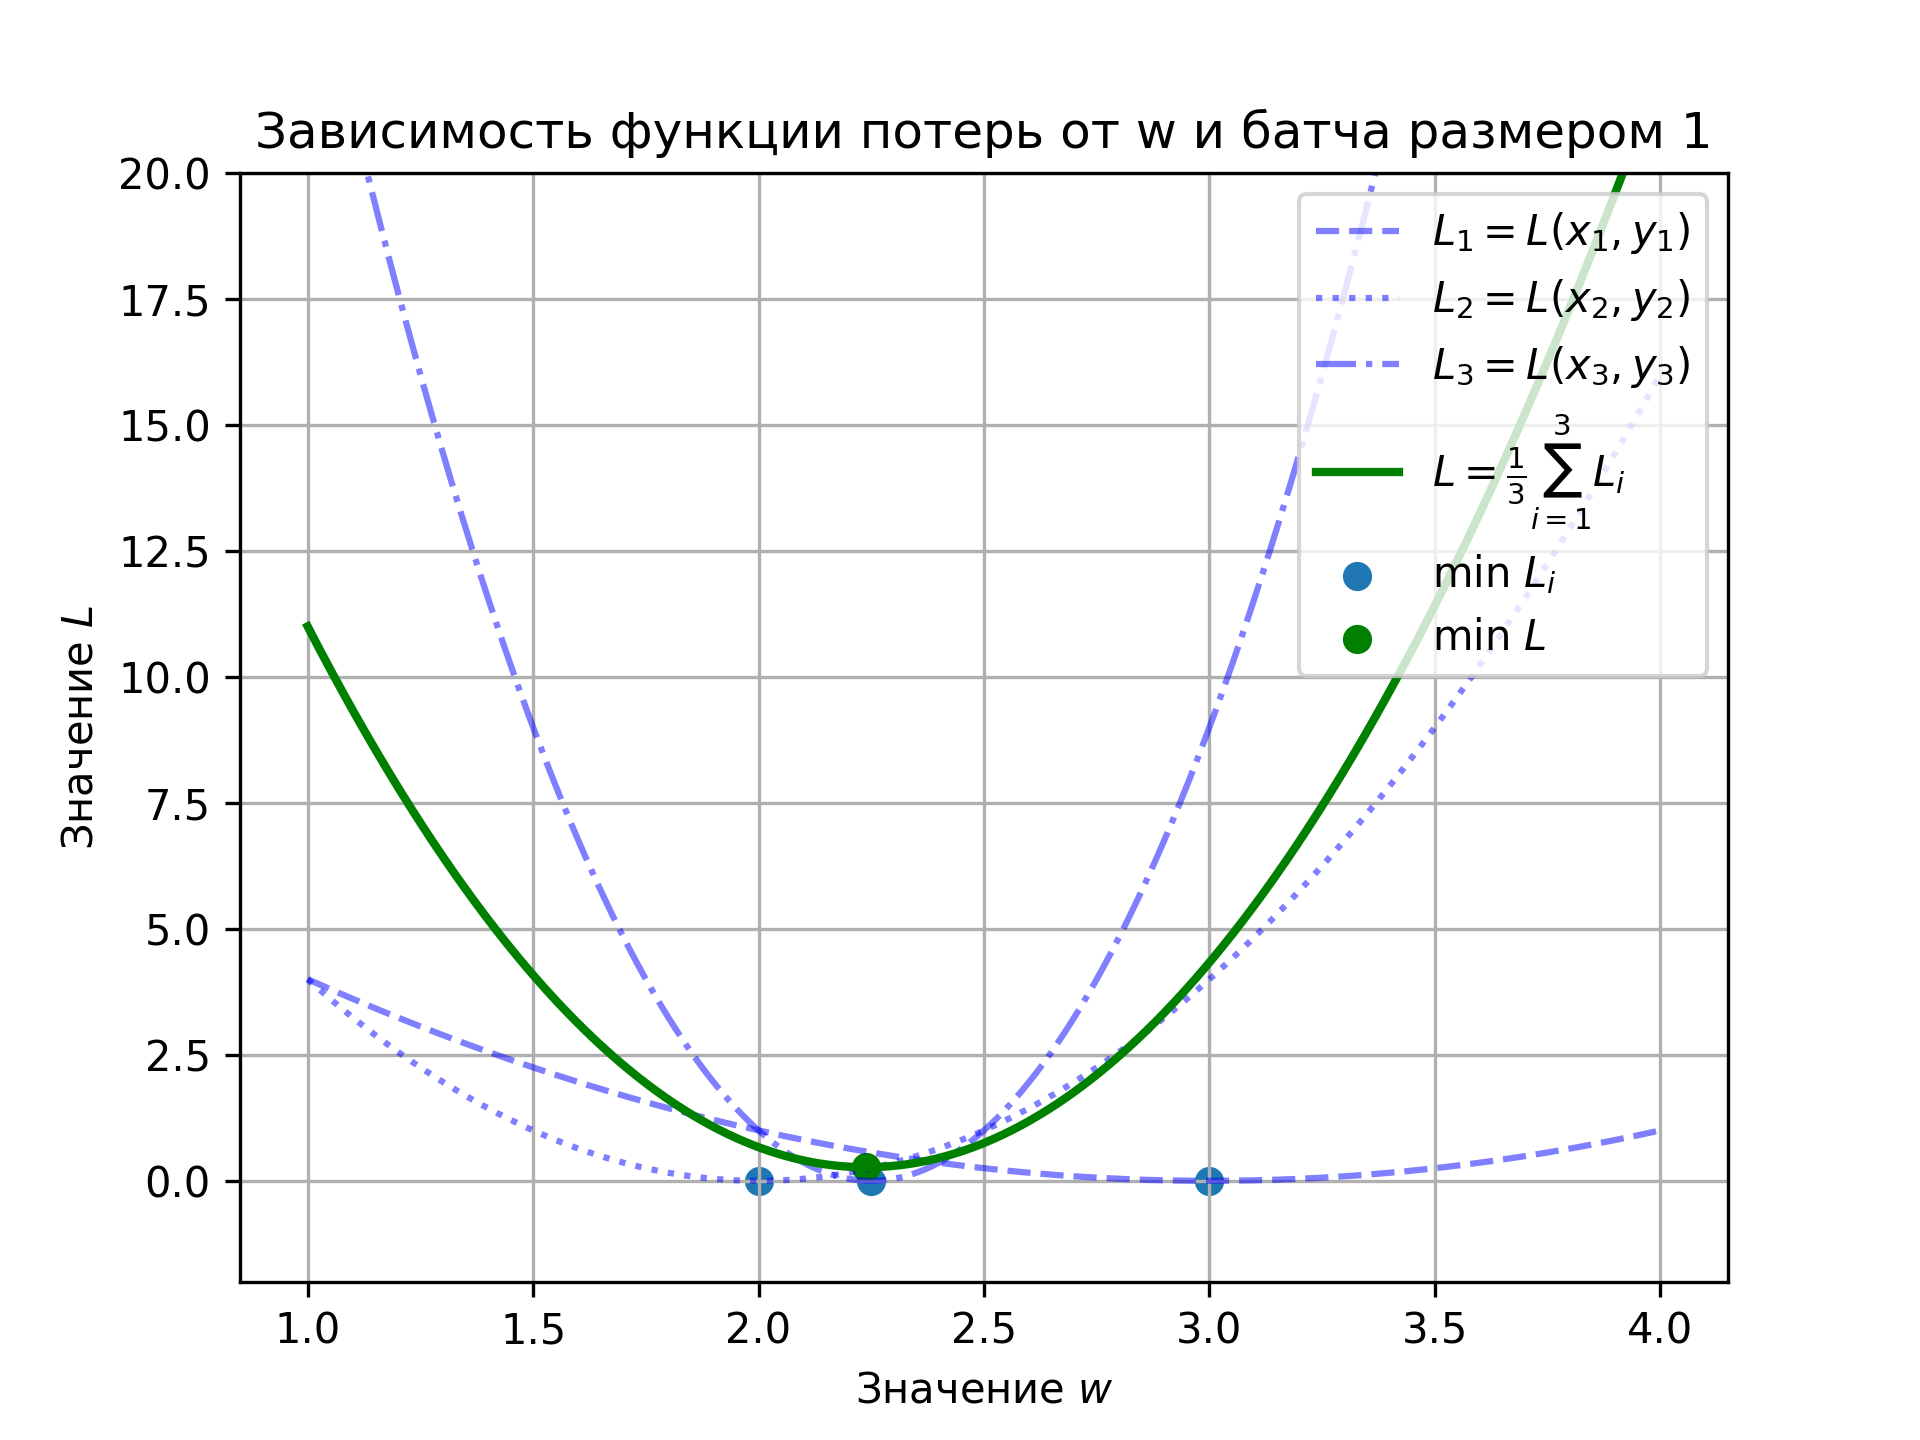

Каждое слагаемое является параболой относительно $x_i$. Мы можем представить процесс оптимизации методом SGD следующим образом: на каждом шаге случайно выбирается одна парабола, делается шаг

$$
\eta \cdot x_i (w x_i - y_i),
$$

который направлен в сторону вершины этой параболы (так как это оптимум для неё). Если предположить, что задача регрессии имеет «красивое» решение, то вершины всех парабол находятся примерно около друг друга и есть какое-то «среднее» оптимальное место. Когда значение $w$ далеко от этого места, SGD безошибочно идёт в его сторону. Но когда SGD приближается к оптимуму, есть вероятность, что случайно выбранная парабола будет в направлении, противоположном оптимуму. Поэтому SGD никогда не сойдётся к оптимуму, а будет осциллировать в регионе неопределённости.

Это свойство SGD является недостатком с точки зрения методов оптимизации. Но мы решаем не просто задачу оптимизации, а задачу машинного обучения, в которой, как правило, запрещено идеально подгоняться под обучающую выборку. С этой точки зрения SGD вносит регуляризацию.

Это свойство особенно полезно в контексте глубокого обучения, потому что для многослойных сетей ландшафт функции потерь представляет собой «минное поле» с разбросанными минами &ndash; плохими локальными оптимумами. Стохастическая оптимизация позволяет обходить узкие локальные оптимумы, в то время как точный градиент просто ищет ближайший.